In [1]:
import time
import os 
import numpy as np
from scipy import sparse
import pandas as pd
import h5py
import anndata
import matplotlib.pyplot as plt
import itertools

from dredFISH.Utils import basicu
from dredFISH.Utils.__init__plots import *

In [2]:
ddir = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/'
res_dir = '/bigstore/GeneralStorage/fangming/projects/dredfish/res_dpnmf/v_python'

In [3]:
# read in data
f = os.path.join(ddir, 'scrna_ss_ctxhippo_a_exon_count_matrix_v5.h5ad')
adata = anndata.read(f)

In [4]:
# get the genes
f = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/pshop_smart_l5n100_cpm1_genes.txt'
sel_genes = np.loadtxt(f, dtype=str)
sel_genes.shape

(10186,)

In [5]:
# select those genes only
sel_genes_idx = basicu.get_index_from_array(adata.var.index.values, sel_genes)
assert (sel_genes_idx == -1).sum() == 0
adata_sel = adata[:,adata.var.iloc[sel_genes_idx].index].copy()

In [6]:
# coverage norm
cov = np.asarray(adata.X.sum(axis=1)).flatten()
# medcov = np.median(cov)
covscale = cov/1e6 # medcov

adata_sel.layers['norm'] = adata_sel.X.toarray()/covscale.reshape(-1,1)

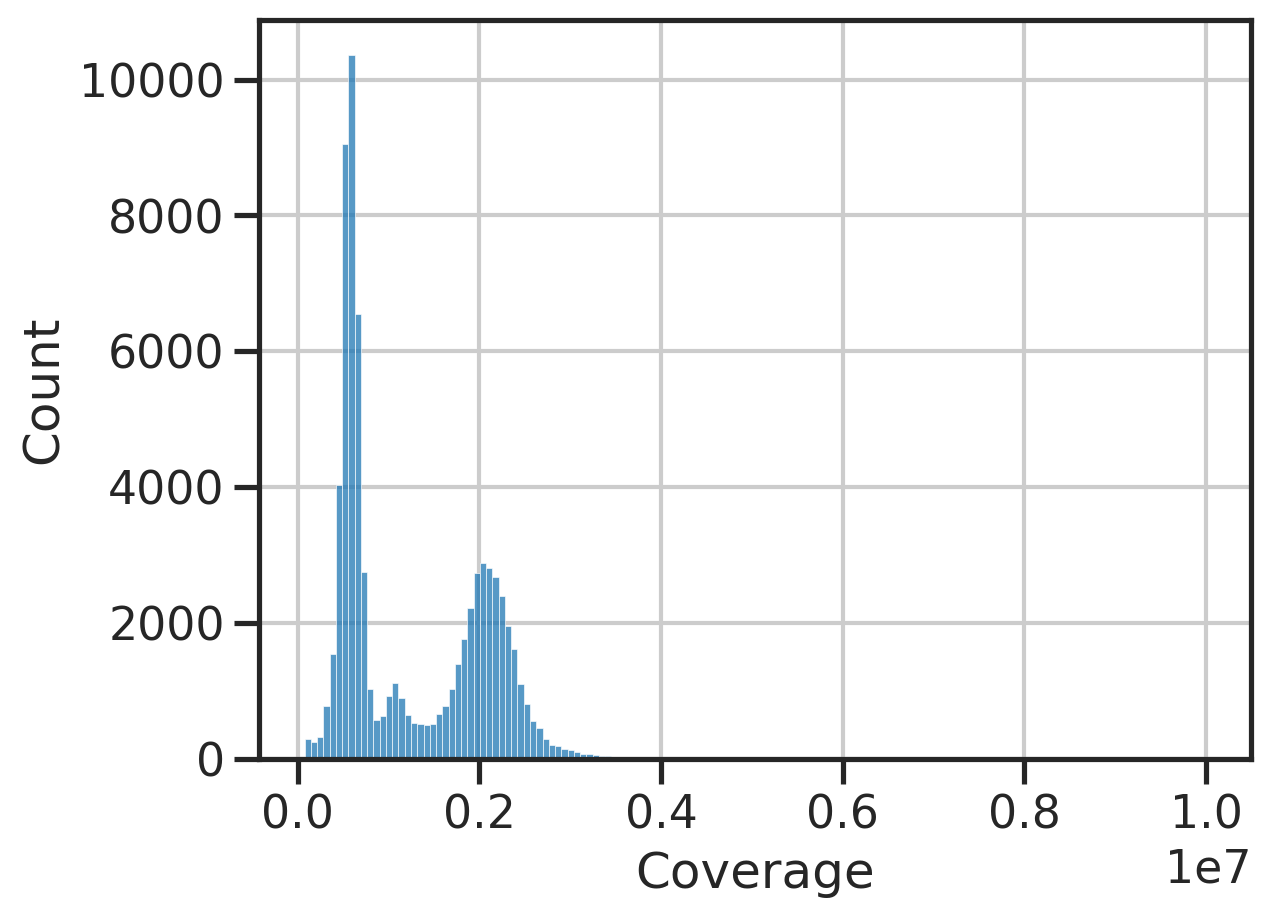

In [7]:
fig, ax = plt.subplots()
ax.set_xlabel('Coverage')
sns.histplot(cov, ax=ax)
# ax.axvline(medcov, color='k', linestyle='--')
plt.show()

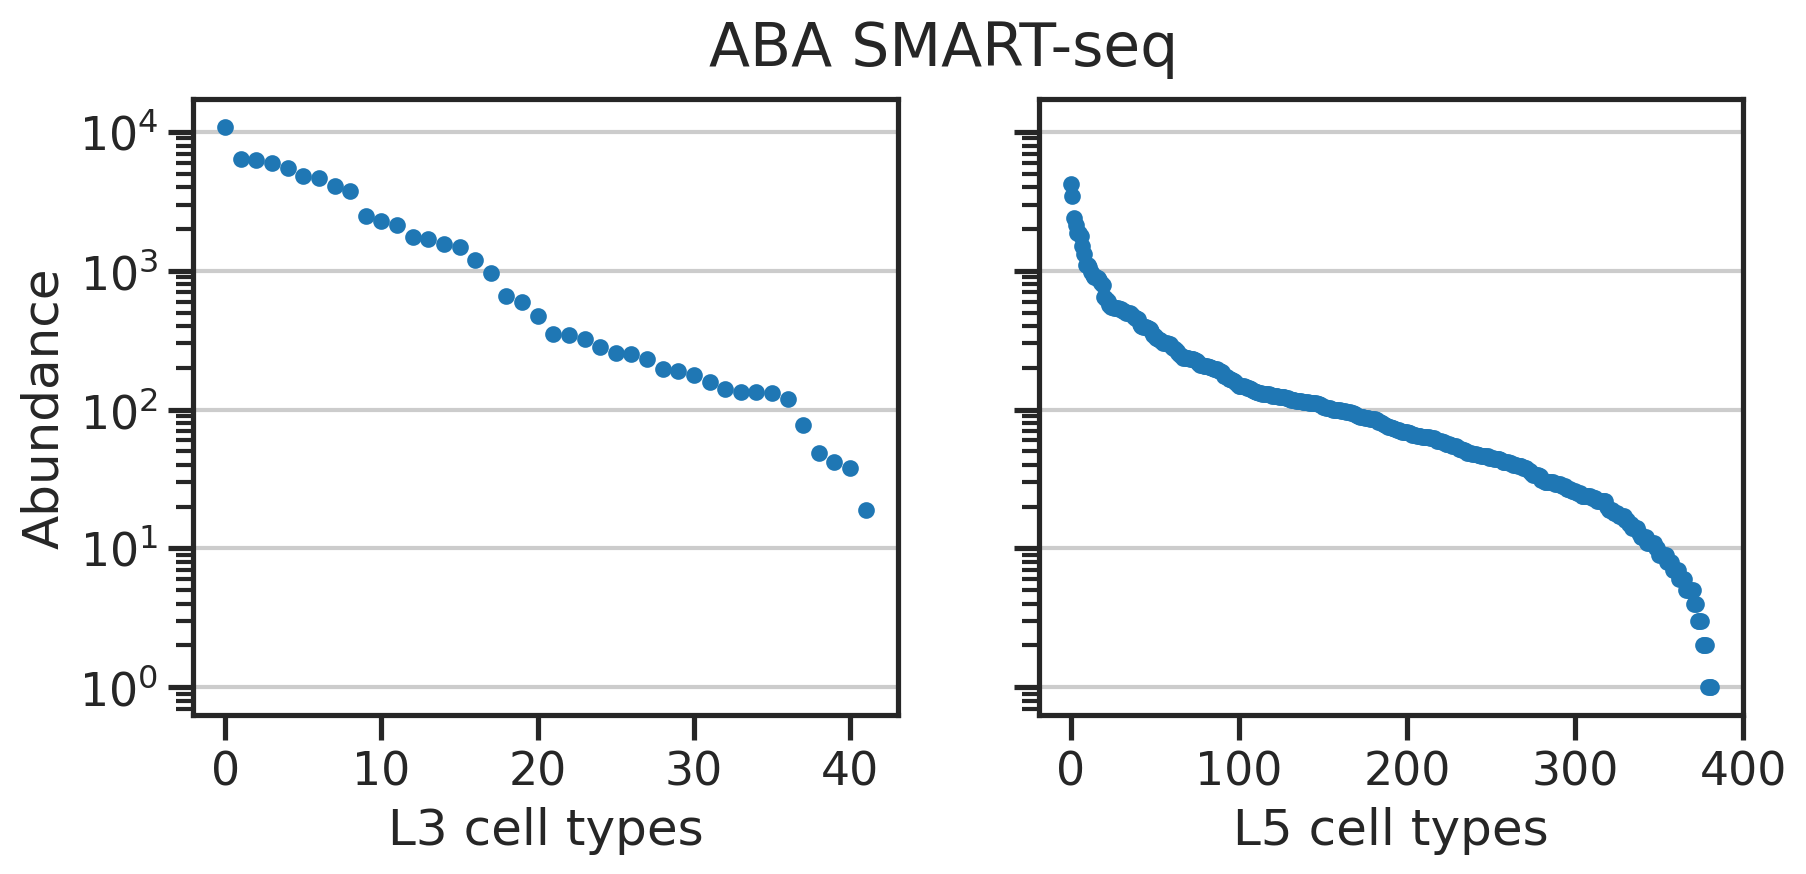

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(5*2,4), sharey=True)
ax = axs[0]
ax.plot(adata_sel.obs['subclass_label'].value_counts().values, 'o', markersize=5)
ax.grid(False, axis='x')
ax.set_yscale('log')
ax.set_xlabel('L3 cell types')
ax.set_ylabel('Abundance')

ax = axs[1]
ax.plot(adata_sel.obs['cluster_label'].value_counts().values, 'o', markersize=5)
ax.grid(False, axis='x')
ax.set_yscale('log')
ax.set_xlabel('L5 cell types')
# ax.set_ylabel('Abundance')
fig.suptitle('ABA SMART-seq')
plt.show()

In [10]:
ns = [
    # 10, 
    100, 
    # 1000,
]
cols = {
    # 'L3': 'subclass_label', 
    'L5': 'cluster_label',
    }
name0 = 'smrt'

configs = []
# get all combinations
for n, colkey in itertools.product(ns, cols.keys()):
    clstcol = cols[colkey]
    # name0, namex, namey, n, clstcol
    config = ('smrt_withrep', f'sub{colkey}n{n}', colkey, n, clstcol)
    configs.append(config)
    
configs

[('smrt_withrep', 'subL5n100', 'L5', 100, 'cluster_label')]

In [11]:
for config in configs:
    print(config)
    name0, namex, namey, n, clstcol = config
    
    # randomly select cells L5 (allow oversample)
    dfsub, idxsub = basicu.stratified_sample_withrep(
                                             adata_sel.obs, clstcol, n, 
                                             return_idx=True, group_keys=False, sort=False, 
                                             random_state=0, 
                                            )
    adatasub = adata_sel[adata_sel.obs.iloc[idxsub].index].copy()

    # convert to dense and format it; need the matrix and the labels
    Xcell = adatasub.obs.index.values
    # X = adatasub.X.toarray().T
    X = adatasub.layers['norm'].T # normalized counts
    y = adatasub.obs[clstcol].values

    # output
    out_Xcell = os.path.join(res_dir, f'{name0}_X_{namex}_cells.csv') 
    out_X     = os.path.join(res_dir, f'{name0}_X_{namex}.npy') 
    out_y     = os.path.join(res_dir, f'{name0}_X_{namex}_y_{namey}.npy') 
    
    pd.DataFrame(Xcell).to_csv(out_Xcell)
    np.save(out_X, X)
    np.save(out_y, y)
    

('smrt_withrep', 'subL5n100', 'L5', 100, 'cluster_label')


/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
# name0, namex, namey1, n, clstcol1 = ('smrt', 'all', 'L3', 0, 'subclass_label')
# namey2, clstcol2 = ('L5', 'cluster_label')

# # convert to dense and format it; need the matrix and the labels
# Xcell = adata_nng.obs.index.values
# # X = adata_nng.X.toarray().T
# X = adata_nng.layers['norm'].T
# y1 = adata_nng.obs[clstcol1].values
# y2 = adata_nng.obs[clstcol2].values

# # output
# out_Xcell = os.path.join(res_dir, f'{name0}_X_{namex}_cells.csv') 
# out_X = os.path.join(res_dir, f'{name0}_X_{namex}.npy') 
# out_y1 = os.path.join(res_dir, f'{name0}_X_{namex}_y_{namey1}.npy') 
# out_y2 = os.path.join(res_dir, f'{name0}_X_{namex}_y_{namey2}.npy') 

# pd.DataFrame(Xcell).to_csv(out_Xcell)
# np.save(out_X, X)
# np.save(out_y1, y1)
# np.save(out_y2, y2)